In [1]:
%matplotlib inline

import os
import sys

PACKAGE_PARENT = '..'
sys.path.append(PACKAGE_PARENT)

import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from gaminet import GAMINetRegressor
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

## Load data

In [2]:
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split

random_state = 0
x, y = make_friedman1(n_samples=10000, n_features=10, noise=0.1, random_state=random_state)
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)
get_metric = lambda label, pred: np.mean((label.ravel() - pred.ravel()) ** 2)

## Compare with EBM

In [3]:
from interpret.glassbox import ExplainableBoostingRegressor

clf = ExplainableBoostingRegressor(interactions=10, feature_names=["X"+str(i+1) for i in range(train_x.shape[1])])
clf.fit(train_x, train_y)

pred_train = clf.predict(train_x)
pred_test = clf.predict(test_x)
ebm_stat = np.hstack([np.round(get_metric(train_y, pred_train),5),
                      np.round(get_metric(test_y, pred_test),5)])
print(ebm_stat)

[0.06058 0.10635]


In [4]:
from ebm_module.expapi import EBMExplainer
exp = EBMExplainer(clf)
exp.fit(train_x)

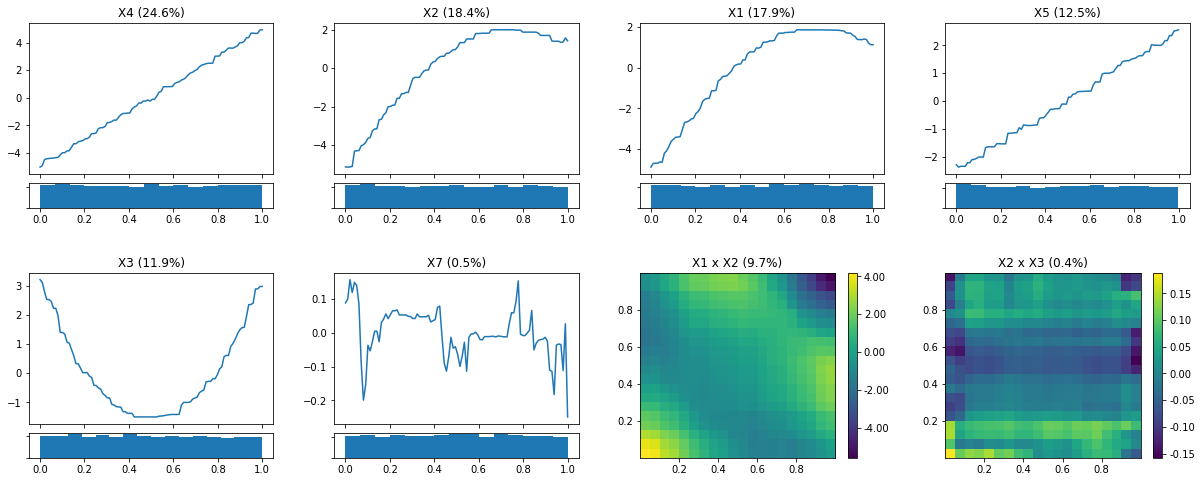

In [5]:
exp.show_global_explain(main_effect_num=6, interaction_num=2)

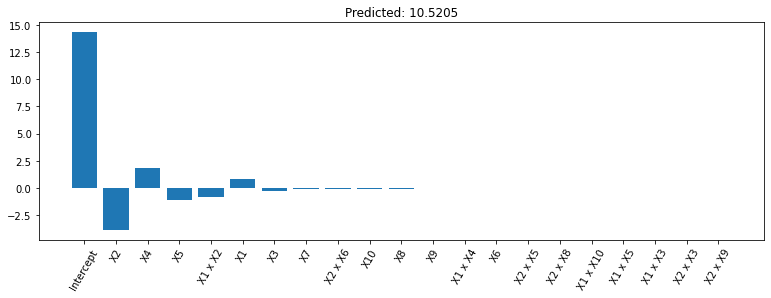

In [6]:
exp.show_local_explain(train_x[[0]])

## Train GAMI-Net 

In [7]:
model = GAMINetRegressor(interact_num=10,
                         subnet_size_main_effect=(20, ),
                         subnet_size_interaction=(20, 20), 
                         max_epochs=(1000, 1000, 1000),
                         learning_rates=(0.001, 0.001, 0.0001),
                         early_stop_thres=("auto", "auto", "auto"),
                         batch_size=1000,
                         reg_clarity=0.1,
                         loss_threshold=0.01,
                         normalize=True,
                         warm_start=True,
                         verbose=True,
                         random_state=random_state)
model.fit(train_x, train_y)

###############Run Warm Initialization for Main Effect###############
####################Stage 1: Main Effect Training####################


Epoch:    1, train loss: 1.77978, validation loss: 1.78927: 100%|██████████| 7/7 [00:00<00:00, 27.53it/s]                          
Epoch:    2, train loss: 1.77460, validation loss: 1.79031: 100%|██████████| 7/7 [00:00<00:00, 221.00it/s]                         
Epoch:    3, train loss: 1.77424, validation loss: 1.79806: 100%|██████████| 7/7 [00:00<00:00, 229.91it/s]                         
Epoch:    4, train loss: 1.77143, validation loss: 1.79074: 100%|██████████| 7/7 [00:00<00:00, 235.18it/s]                         
Epoch:    5, train loss: 1.77412, validation loss: 1.79044: 100%|██████████| 7/7 [00:00<00:00, 230.56it/s]                         
Epoch:    6, train loss: 1.76972, validation loss: 1.79145: 100%|██████████| 7/7 [00:00<00:00, 236.80it/s]                         
Epoch:    7, train loss: 1.76987, validation loss: 1.79239: 100%|██████████| 7/7 [00:00<00:00, 234.99it/s]                         
Epoch:    8, train loss: 1.76895, validation loss: 1.78941: 100%|██████████|

Main Effect Training Stop at Epoch: 9, train loss: 1.76862, validation loss: 1.79666
###############Run Warm Initialization for Interaction###############
####################Stage 2: Interaction Training####################


Epoch:    1, train loss: 0.02178, validation loss: 0.02427: 100%|██████████| 7/7 [00:00<00:00, 37.22it/s]                          
Epoch:    2, train loss: 0.02440, validation loss: 0.02275: 100%|██████████| 7/7 [00:00<00:00, 79.76it/s]                          
Epoch:    3, train loss: 0.02438, validation loss: 0.02396: 100%|██████████| 7/7 [00:00<00:00, 78.89it/s]                          
Epoch:    4, train loss: 0.02105, validation loss: 0.02408: 100%|██████████| 7/7 [00:00<00:00, 74.05it/s]                          
Epoch:    5, train loss: 0.02281, validation loss: 0.02110: 100%|██████████| 7/7 [00:00<00:00, 74.91it/s]                          
Epoch:    6, train loss: 0.02048, validation loss: 0.02174: 100%|██████████| 7/7 [00:00<00:00, 82.53it/s]                          
Epoch:    7, train loss: 0.01968, validation loss: 0.02145: 100%|██████████| 7/7 [00:00<00:00, 79.55it/s]                          
Epoch:    8, train loss: 0.01985, validation loss: 0.02127: 100%|██████████|

Interaction Training Stop at Epoch: 23, train loss: 0.01941, validation loss: 0.02014
#########################Stage 3: Fine Tuning#########################


Epoch:    1, train loss: 0.01867, validation loss: 0.01966: 100%|██████████| 7/7 [00:00<00:00, 75.69it/s]                          
Epoch:    2, train loss: 0.01798, validation loss: 0.01932: 100%|██████████| 7/7 [00:00<00:00, 76.02it/s]                          
Epoch:    3, train loss: 0.01766, validation loss: 0.01930: 100%|██████████| 7/7 [00:00<00:00, 65.15it/s]                          
Epoch:    4, train loss: 0.01755, validation loss: 0.01930: 100%|██████████| 7/7 [00:00<00:00, 77.68it/s]                          
Epoch:    5, train loss: 0.01748, validation loss: 0.01924: 100%|██████████| 7/7 [00:00<00:00, 75.42it/s]                          
Epoch:    6, train loss: 0.01745, validation loss: 0.01918: 100%|██████████| 7/7 [00:00<00:00, 74.70it/s]                          
Epoch:    7, train loss: 0.01737, validation loss: 0.01904: 100%|██████████| 7/7 [00:00<00:00, 73.84it/s]                          
Epoch:    8, train loss: 0.01728, validation loss: 0.01894: 100%|██████████|

Fine Tuning Stop at Epoch: 119, train loss: 0.01502, validation loss: 0.01714


GAMINetRegressor(batch_size=1000, loss_threshold=0.01, verbose=True)

In [8]:
model.time_cost_

[('fine_tune_all', 11.36),
 ('warm_start_main_effect', 4.36),
 ('warm_start_interaction', 3.92),
 ('fit_interaction', 2.29),
 ('fit_main_effect', 0.56),
 ('add_interaction', 0.17),
 ('get_interaction_list', 0.14),
 ('prune_interaction', 0.14),
 ('prune_main_effect', 0.13)]

In [9]:
pred_train = model.predict(train_x)
pred_test = model.predict(test_x) 

gaminet_stat = np.hstack([np.round(get_metric(train_y, pred_train),5),
                          np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

[0.01542 0.01571]


/root/zebin/projects/GAMINet_Pytorch/examples/../gaminet/base.py:1627: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  plt.ylim(-absmax, absmax)


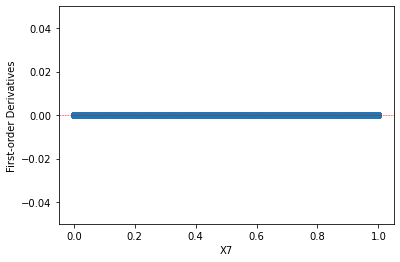

In [10]:
model.partial_derivatives(6)

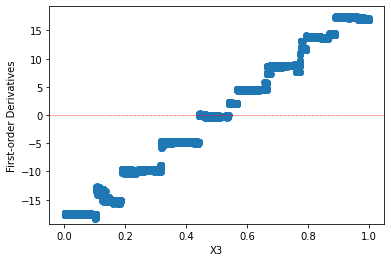

In [11]:
model.partial_derivatives(2)

In [12]:
model.get_mono_loss(train_x), model.certify_mono(n_samples=10000)

(0.0, True)

In [13]:
model.get_clarity_loss(test_x)

0.06476517021656036

## Visualization

### Training details

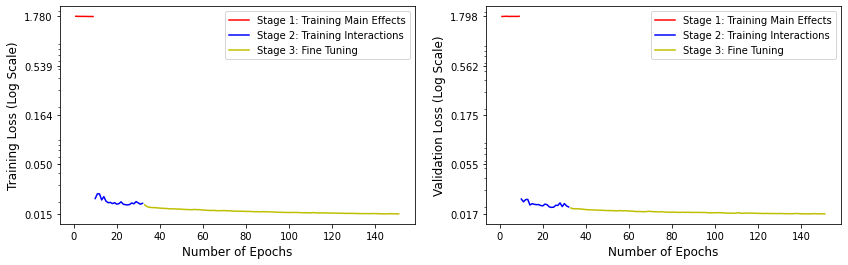

In [14]:
model.show_loss_trajectory()

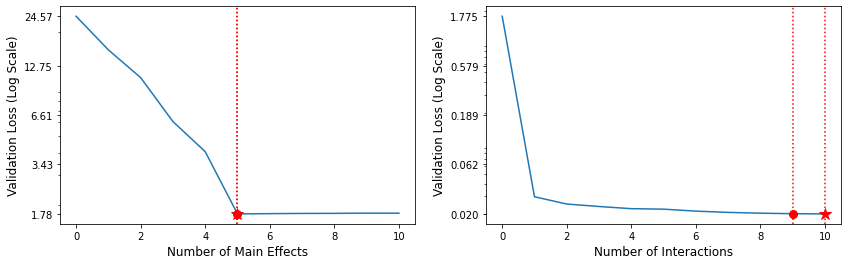

In [15]:
model.show_regularization_path()

### Global explaination

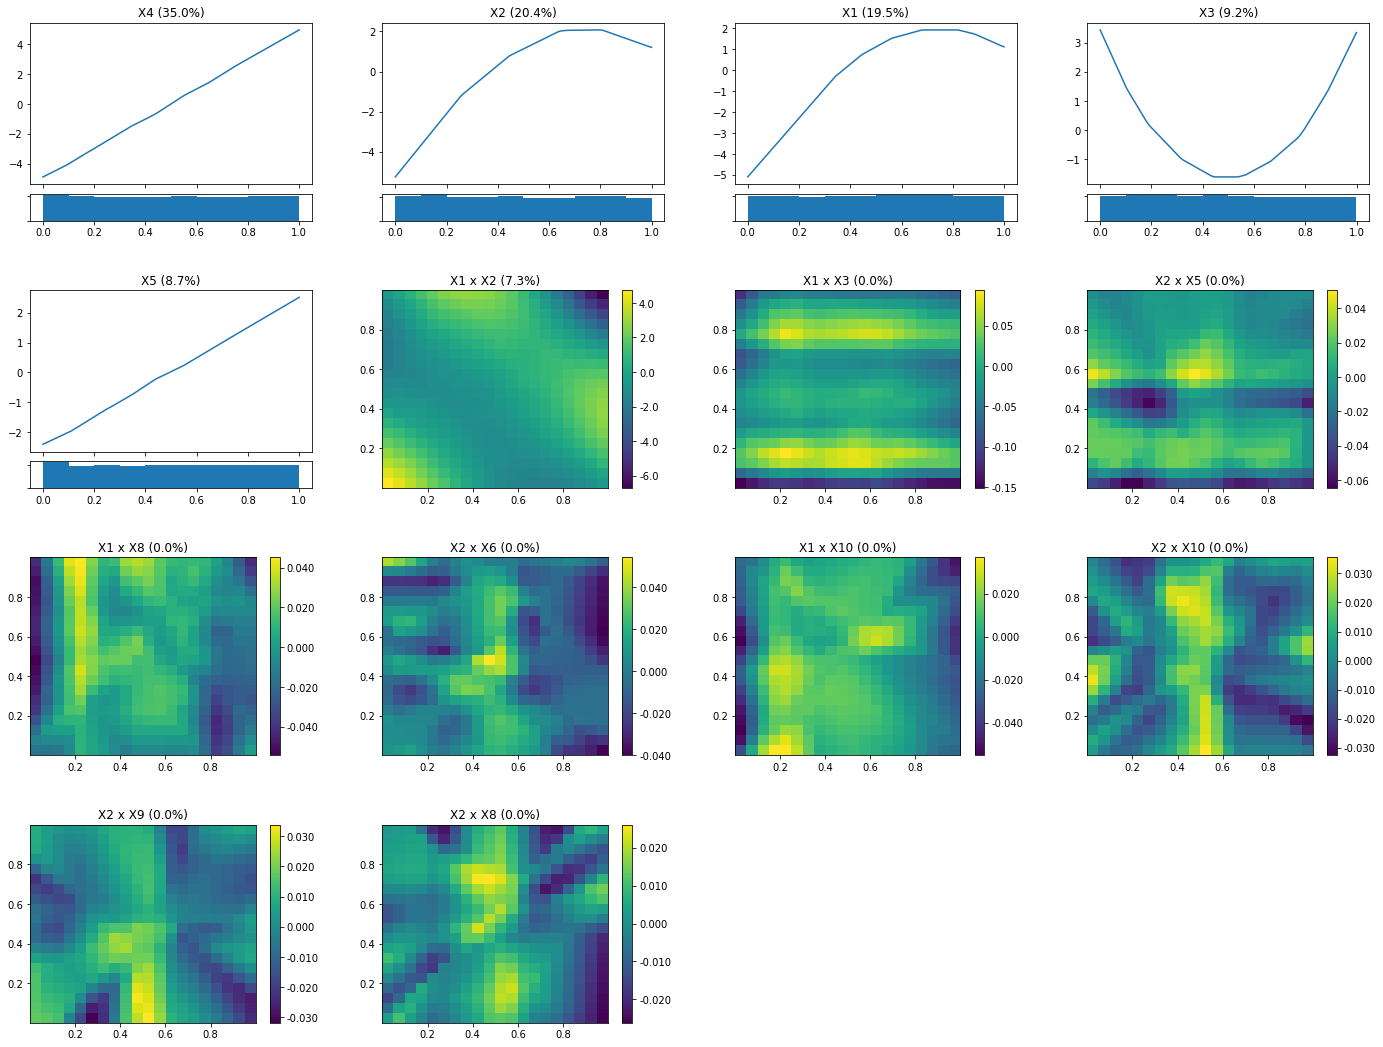

In [16]:
# show all effects 
model.show_global_explain()

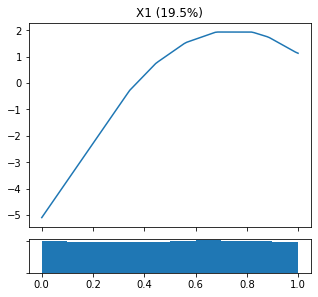

In [17]:
# show one specific effect
model.show_global_explain(key="X1")

### Feature and effect importance

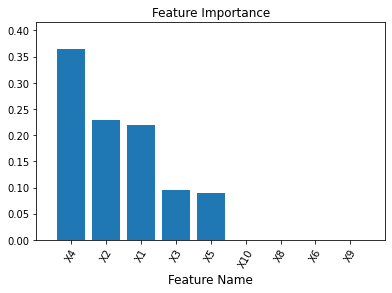

In [18]:
## feature importance 
model.show_feature_importance()

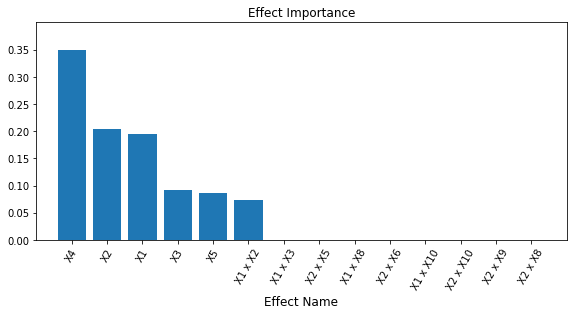

In [19]:
## effect importance 
model.show_effect_importance()

### Local Explain

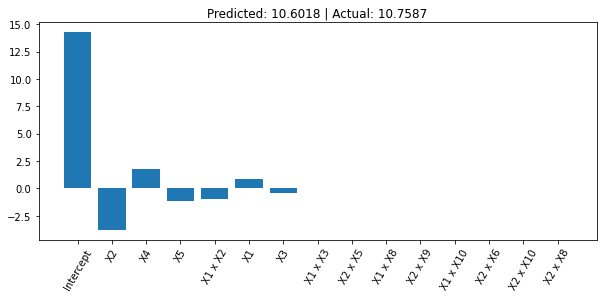

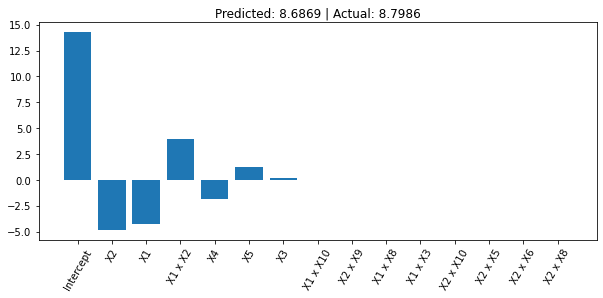

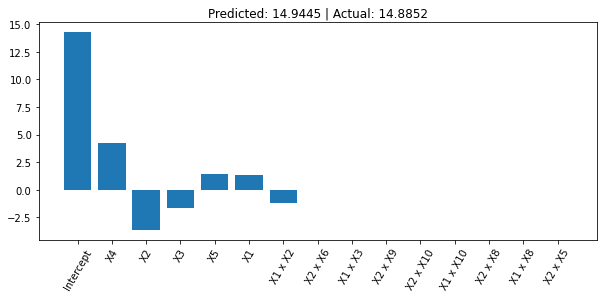

In [20]:
## explain single sample 
model.show_local_explain(train_x[:3], train_y[:3])